In [1]:
import os
import csv
import shapefile
import pysal
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Set and check the data path

In [3]:
data_dir = os.path.abspath('Data')
geom_file = os.path.join(data_dir, 'NYC_sample_geometries.csv')
flow_file = os.path.join(data_dir, 'NYC_sample_flow.csv')

if os.path.exists(geom_file):
    print('Input file:', geom_file, flow_file)
else:
    print('Data directory is:', data_dir)
    print('Please fix the path!')

('Input file:', "C:\\Users\\Scarlett's Laptop\\Documents\\Git\\Project\\NYC-hexagon-outlier-detection\\Data\\NYC_sample_geometries.csv", "C:\\Users\\Scarlett's Laptop\\Documents\\Git\\Project\\NYC-hexagon-outlier-detection\\Data\\NYC_sample_flow.csv")


# 1. Create the shapefile
reference: http://geospatialpython.com/2015/08/csv-to-shapefile.html

In [4]:
# Create a polygon shapefile writer
wrt = shapefile.Writer(shapefile.POLYGON)

In [5]:
# Add fields
wrt.field('AreaId', 'N', 6, 0)

In [6]:
# Open the csv file and set up a reader
with open(geom_file) as p:
    reader = csv.DictReader(p)
    for row in reader:
        # Add records for each polygon
        wrt.record(row['AreaId'])
        # Parse the coordinate string
        wkt = row['Geometry'][15:-3]
        # Break the coordinate string into x,y coordinates
        coords = wkt.split(",")
        # Set up a list to contain the coordinates for each node
        part = []
        # Convert the x,y values to floats
        for c in coords:
            x,y = c.split(' ')
            part.append([float(x), float(y)])
        # Create a polygon record with the list of coordinates
        wrt.poly(parts=[part])

In [7]:
# Save the shapefile
wrt.save('NYC_sample_hexagons.shp')

# 2. Create the neighbor list
For each AreaId, detect its neighbors, i.e. the polygons that share a common edge. 

In [8]:
nb = pysal.rook_from_shapefile('NYC_sample_hexagons.shp', 'AreaId')

In [9]:
type(nb.neighbors)

dict

In [10]:
hist = pd.DataFrame(nb.histogram, columns=['bin', 'cnt'])

<Container object of 5 artists>

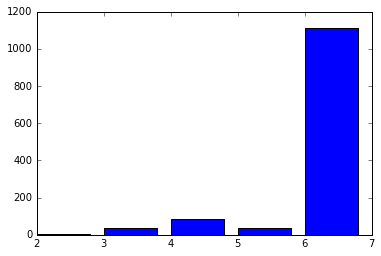

In [11]:
plt.bar(hist.bin,hist.cnt)

# 3. Final output 

In [12]:
# Read in nyc_flow.csv and pivot the table
flow = pd.read_csv(flow_file)

In [13]:
areaIds = list(set(flow.AreaId)) # iterate through a list is faster than through a set

In [14]:
flow = flow.set_index(['AreaId', 'StartTime'])

In [15]:
flow.head()

NewCount
AreaId StartTime                    
229777 2015-09-01 00:00:00       304
       2015-09-01 01:00:00       100
       2015-09-01 02:00:00        52
       2015-09-01 03:00:00       304
       2015-09-01 04:00:00       248

In [16]:
all_neighbors_mean_counts = pd.DataFrame()
for areaId in areaIds:
    neighbors = set(nb.neighbors[areaId])
    neighbors_df = flow[flow.index.isin(neighbors, level='AreaId')]
    neighbors_mean_count = neighbors_df.mean(level='StartTime').reset_index()
    neighbors_mean_count['AreaId'] = areaId
    all_neighbors_mean_counts = all_neighbors_mean_counts.append(neighbors_mean_count)

In [17]:
all_neighbors_mean_counts.rename(columns={'NewCount':'Average'}, inplace=True)

In [18]:
all_neighbors_mean_counts = all_neighbors_mean_counts.set_index(['AreaId', 'StartTime'])


In [19]:
count_difference = flow.join(all_neighbors_mean_counts)
count_difference['Diff'] = count_difference.NewCount - count_difference.Average 

In [20]:
count_difference.head()

NewCount  Average   Diff
AreaId StartTime                                    
229777 2015-09-01 00:00:00       304    252.5   51.5
       2015-09-01 01:00:00       100    393.5 -293.5
       2015-09-01 02:00:00        52     44.0    8.0
       2015-09-01 03:00:00       304    165.5  138.5
       2015-09-01 04:00:00       248    346.5  -98.5

In [21]:
count_difference.to_csv('NYC_sample_difference.csv')

# 4. Outlier Detection

In [25]:
# count_difference = pd.read_csv('NYC_sample_difference.csv')
nyc_pivot = count_difference.reset_index().pivot(index='AreaId', columns='StartTime', values='NewCount')
nyc_pivot.fillna(value=0, inplace=True)

In [26]:
nyc_pivot.head()

StartTime,2015-09-01 00:00:00,2015-09-01 01:00:00,2015-09-01 02:00:00,2015-09-01 03:00:00,2015-09-01 04:00:00,2015-09-01 05:00:00,2015-09-01 06:00:00,2015-09-01 07:00:00,2015-09-01 08:00:00,2015-09-01 09:00:00,...,2015-09-07 14:00:00,2015-09-07 15:00:00,2015-09-07 16:00:00,2015-09-07 17:00:00,2015-09-07 18:00:00,2015-09-07 19:00:00,2015-09-07 20:00:00,2015-09-07 21:00:00,2015-09-07 22:00:00,2015-09-07 23:00:00
AreaId,,,,,,,,,,,,,,,,,,,,,
229777,304,100,52,304,248,133,261,444,466,393,...,438,19,60,295,397,5,194,241,134,391
229778,358,457,49,85,258,475,110,454,7,176,...,19,418,230,347,231,70,385,38,474,252
229779,399,204,274,274,473,215,86,44,258,56,...,408,306,142,243,133,171,402,409,459,183
229780,401,97,117,286,149,401,377,48,95,73,...,306,478,178,193,197,420,215,171,38,232
229781,169,217,26,260,499,365,188,126,27,123,...,261,21,156,333,188,35,281,167,168,252


In [27]:
from sklearn.cluster import AgglomerativeClustering

In [28]:
ward = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(nyc_pivot)
labels=ward.labels_

In [29]:
# Number of clusters in labels
n_clusters_ = len(set(labels)) 
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 2


In [30]:
import numpy as np
unique, counts = np.unique(labels, return_counts=True)
print np.asarray((unique, counts)).T

[[   0    5]
 [   1 1091]]


In [31]:
nyc_pivot['labels'] = labels

In [32]:
nyc_pivot[nyc_pivot['labels']==0]

StartTime,2015-09-01 00:00:00,2015-09-01 01:00:00,2015-09-01 02:00:00,2015-09-01 03:00:00,2015-09-01 04:00:00,2015-09-01 05:00:00,2015-09-01 06:00:00,2015-09-01 07:00:00,2015-09-01 08:00:00,2015-09-01 09:00:00,...,2015-09-07 15:00:00,2015-09-07 16:00:00,2015-09-07 17:00:00,2015-09-07 18:00:00,2015-09-07 19:00:00,2015-09-07 20:00:00,2015-09-07 21:00:00,2015-09-07 22:00:00,2015-09-07 23:00:00,labels
AreaId,,,,,,,,,,,,,,,,,,,,,
229784,3507,2515,4574,3457,3954,1879,4046,2977,1757,3637,...,3470,4768,2095,2410,1490,2246,1322,1956,4925,0
231460,1897,2001,2370,1665,3569,1047,3131,2414,3546,4826,...,1131,1575,1568,1234,3662,2278,1682,1104,4630,0
232200,3516,3130,3058,4884,2268,4615,1498,4568,2805,3724,...,1751,3262,3963,1944,3077,3793,1626,3659,1511,0
233511,0,0,4740,3005,0,3747,4488,1861,3440,2002,...,3045,4164,2726,2589,2616,3131,2872,1628,4134,0
236330,4950,3001,2094,2803,2983,1560,2879,2708,1485,1343,...,4517,3371,4005,3401,4531,1844,3299,1349,4108,0


## Recall that the 5 randomly chosen "high flow" hexagons:
high flow ids are:  set([232200, 229784, 236330, 231460, 233511])
## Successfully detected the 5 outliers!